In [0]:
import threading
import multiprocessing
import time

import numpy as np
import matplotlib.pyplot as plt

import gym
import tensorflow as tf

In [0]:
class ACNet(object):
    def __init__(self, scope, globalAC=None):   
        if scope == net_scope: # global
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, num_obvs], 'S')
                # create global net
                self.actor_params, self.critic_params = self._create_net(scope)[-2:] # only require params
                
        else: # local
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, num_obvs], 'S')
                self.a = tf.placeholder(tf.int32, [None, ], 'A')
                self.critic_target = tf.placeholder(tf.float32, [None, 1], 'critic_target')
                self.baselined_returns = tf.placeholder(tf.float32, [None, 1], 'baselined_returns') # for calculating advantage 
                # create local net
                self.action_prob, self.V, self.actor_params, self.critic_params = self._create_net(scope)
                    
                TD_err = tf.subtract(self.critic_target, self.V, name='TD_err')
                with tf.name_scope('actor_loss'):
                    log_prob = tf.reduce_sum(tf.log(self.action_prob + 1e-5) * tf.one_hot(self.a, num_actions, dtype=tf.float32), axis=1, keep_dims=True)
                    actor_component = log_prob * tf.stop_gradient(self.baselined_returns)
                    # entropy for exploration
                    entropy = -tf.reduce_sum(self.action_prob * tf.log(self.action_prob + 1e-5), axis=1, keep_dims=True)  # encourage exploration
                    self.actor_loss = tf.reduce_mean( -(ENTROPY_BETA * entropy + actor_component) )                                        
                with tf.name_scope('critic_loss'):
                    self.critic_loss = tf.reduce_mean(tf.square(TD_err))                      
                # accumulated gradients for local actor    
                with tf.name_scope('local_actor_grad'):                   
                    self.actor_zero_op, self.actor_accumu_op, self.actor_apply_op, actor_accum = self.accumu_grad(OPT_A, self.actor_loss, scope=scope + '/actor')
                # accumulated gradients for local critic    
                with tf.name_scope('local_critic_grad'):
                    self.critic_zero_op, self.critic_accumu_op, self.critic_apply_op, critic_accum = self.accumu_grad(OPT_C, self.critic_loss, scope=scope + '/critic')
                    
            with tf.name_scope('params'): # push/pull from local/worker perspective
                with tf.name_scope('push_to_global'):
                    self.push_actor_params = OPT_A.apply_gradients(zip(actor_accum, globalAC.actor_params))
                    self.push_critic_params = OPT_C.apply_gradients(zip(critic_accum, globalAC.critic_params))
                with tf.name_scope('pull_fr_global'):
                    self.pull_actor_params = [local_params.assign(global_params) for local_params, global_params in zip(self.actor_params, globalAC.actor_params)]
                    self.pull_critic_params = [local_params.assign(global_params) for local_params, global_params in zip(self.critic_params, globalAC.critic_params)]                    
                    
    def _create_net(self, scope):
        w_init = tf.glorot_uniform_initializer()
        with tf.variable_scope('actor'):
            hidden = tf.layers.dense(self.s, actor_hidden, tf.nn.relu6, kernel_initializer=w_init, name='hidden')
            action_prob = tf.layers.dense(hidden, num_actions, tf.nn.softmax, kernel_initializer=w_init, name='action_prob')        
        with tf.variable_scope('critic'):
            hidden = tf.layers.dense(self.s, critic_hidden, tf.nn.relu6, kernel_initializer=w_init, name='hidden')
            V = tf.layers.dense(hidden, 1, kernel_initializer=w_init, name='V')         
        actor_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
        critic_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')       
        return action_prob, V, actor_params, critic_params

    def accumu_grad(self, OPT, loss, scope):
        # retrieve trainable variables in scope of graph
        #tvs = tf.trainable_variables(scope=scope + '/actor')
        tvs = tf.trainable_variables(scope=scope)
        # ceate a list of variables with the same shape as the trainable
        accumu = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in tvs]
        zero_op = [tv.assign(tf.zeros_like(tv)) for tv in accumu] # initialized with 0s
        gvs = OPT.compute_gradients(loss, tvs) # obtain list of gradients & variables
        #gvs = [(tf.where( tf.is_nan(grad), tf.zeros_like(grad), grad ), var) for grad, var in gvs]
        # adds to each element from the list you initialized earlier with zeros its gradient 
        # accumu and gvs are in same shape, index 0 is grads, index 1 is vars
        accumu_op = [accumu[i].assign_add(gv[0]) for i, gv in enumerate(gvs)]
        apply_op = OPT.apply_gradients([(accumu[i], gv[1]) for i, gv in enumerate(gvs)]) # apply grads
        return zero_op, accumu_op, apply_op, accumu      
      
    def push_global_actor(self, feed_dict):  
        SESS.run([self.push_actor_params], feed_dict)  

    def push_global_critic(self, feed_dict):  
        SESS.run([self.push_critic_params], feed_dict)         
        
    def pull_global(self):  
        SESS.run([self.pull_actor_params, self.pull_critic_params])

    def choose_action(self, s):  
        prob_weights = SESS.run(self.action_prob, feed_dict={self.s: s[None, :]})
        action = np.random.choice(range(prob_weights.shape[1]), p=prob_weights.ravel()) 
        return action             
        
    def init_grad_storage_actor(self):
        SESS.run(self.actor_zero_op)
        
    def accumu_grad_actor(self, feed_dict):
        SESS.run([self.actor_accumu_op], feed_dict)          
    
    def apply_accumu_grad_actor(self, feed_dict):
        SESS.run([self.actor_apply_op], feed_dict)   
        
    def init_grad_storage_critic(self):
        SESS.run(self.critic_zero_op)
        
    def accumu_grad_critic(self, feed_dict):
        SESS.run([self.critic_accumu_op], feed_dict)          
    
    def apply_accumu_grad_critic(self, feed_dict):
        SESS.run([self.critic_apply_op], feed_dict)  

In [0]:
class Worker(object): # local only
    def __init__(self, name, globalAC):
        self.env = gym.make(game)
        self.name = name
        self.AC = ACNet(name, globalAC)
    def work(self):
        global GLOBAL_RUNNING_R, GLOBAL_EP
        T = 0
        t = 0
        while not COORD.should_stop() and GLOBAL_EP < max_global_episodes:
            s = self.env.reset()
            ep_r = 0 # reward per episode
            done = False
            buffer_s, buffer_a, buffer_r, buffer_done = [], [], [], []
            self.AC.pull_global()
            while not done:
                a = self.AC.choose_action(s)
                s_, r, done, info = self.env.step(a)
                ep_r += r
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r)
                buffer_done.append(done)                
                s = s_
                t += 1
            
            # if statement will always be done in this case... 
            # possible future modification
            if done:
                V_s = 0   
            else:
                V_s = SESS.run(self.AC.V, {self.AC.s: s[None, :]})[0, 0] # takes in just one s, not a batch.
            
            # critic related
            critic_target = self.discount_rewards(buffer_r, GAMMA, V_s)
            
            buffer_s, buffer_a, critic_target = np.vstack(buffer_s), np.array(buffer_a), np.vstack(critic_target)
            feed_dict = {self.AC.s: buffer_s, self.AC.critic_target: critic_target}                         
            self.AC.accumu_grad_critic(feed_dict) # accumulating gradients for local critic  
            self.AC.apply_accumu_grad_critic(feed_dict) 
            
            baseline = SESS.run(self.AC.V, {self.AC.s: buffer_s}) # Value function
            epr = np.vstack(buffer_r).astype(np.float32)
            n_step_targets = self.compute_n_step_targets_missing(epr, baseline, GAMMA, N_step) # Q values
            # Advantage function
            baselined_returns = n_step_targets - baseline

            feed_dict = {self.AC.s: buffer_s, self.AC.a: buffer_a, self.AC.critic_target: critic_target, self.AC.baselined_returns: baselined_returns}            
            self.AC.accumu_grad_actor(feed_dict) # accumulating gradients for local actor  
            
            # update
            self.AC.push_global_actor(feed_dict)                
            self.AC.push_global_critic(feed_dict)
            buffer_s, buffer_a, buffer_r, buffer_done = [], [], [], []
            self.AC.pull_global()
              
            #if T % delay_rate == 0: # delay clearing of local gradients storage to reduce noise
                # apply to local
                #self.AC.init_grad_storage_actor() # initialize storage for accumulated gradients.
                #self.AC.init_grad_storage_critic() 

            self.AC.init_grad_storage_actor() # initialize storage for accumulated gradients.
            self.AC.init_grad_storage_critic() 
                
            GLOBAL_RUNNING_R.append(ep_r) # for display
            GLOBAL_EP += 1                           
      
    def discount_rewards(self, r, gamma, running_add):
      """Take 1D float array of rewards and compute discounted reward """
      discounted_r = np.zeros_like(r)
      #running_add = 0
      for t in reversed(range(len(r))):
          running_add = running_add * gamma + r[t]
          discounted_r[t] = running_add
      return discounted_r 
  
    # As n increase, variance increase.
    # Create a function that returns an array of n-step targets, one for each timestep:
    # target[t] = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... + \gamma^n V(s_{t+n})
    # Where r_t is given by episode reward (epr) and V(s_n) is given by the baselines.
    def compute_n_step_targets_missing(self, epr, baselines, gamma, N):
      targets = np.zeros_like(epr)    
      if N > epr.size:
        N = epr.size
      for t in range(epr.size):    
        for n in range(N):
          if t+n == epr.size:            
            break # missing terms treated as 0
          if n == N-1: # last term
            targets[t] += (gamma**n) * baselines[t+n]
          else:
            targets[t] += (gamma**n) * epr[t+n] 
      return targets   

In [0]:
game = 'CartPole-v0'
#env = gym.make(game).unwrapped
env = gym.make(game)

num_obvs = env.observation_space.shape[0]
num_actions = env.action_space.n

net_scope = 'global'
max_global_episodes = 500
delay_rate = 4000 # T steps

#num_workers = multiprocessing.cpu_count()
num_workers = 4 #16

GAMMA = 0.999 #0.99
ENTROPY_BETA = 0.1 #0.01
actor_alpha = 0.01   
critic_alpha = 0.01   
actor_hidden = 128 #200
critic_hidden = 128 #200
N_step = 15

W0617 13:33:29.885300 140712893831040 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0617 13:33:29.887572 140712893831040 deprecation.py:323] From <ipython-input-2-cf49427a73a9>:45: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0617 13:33:30.344607 140712893831040 deprecation.py:506] From <ipython-input-2-cf49427a73a9>:20: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W0617 13:33:30.361192 140712893831040 deprecati

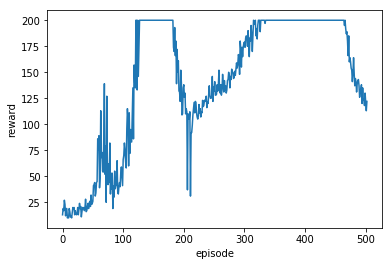

--- 49.19171071052551 seconds ---


In [0]:
start_time = time.time()

SESS = tf.Session()   
with tf.device("/cpu:0"):
    OPT_A = tf.train.AdamOptimizer(actor_alpha, beta1=0.99, beta2=0.999, name='OPT_A')
    OPT_C = tf.train.AdamOptimizer(critic_alpha, beta1=0.99, beta2=0.999, name='OPT_C')

    GLOBAL_AC = ACNet(net_scope, globalAC=None) # only need its params
    workers = []
    for i in range(num_workers): # Create worker
        i_name = 'W_%i' % i # worker name
        workers.append(Worker(i_name, GLOBAL_AC))   
        
    GLOBAL_RUNNING_R = []
    GLOBAL_EP = 0
        
    COORD = tf.train.Coordinator()
    SESS.run(tf.global_variables_initializer())
            
    worker_threads = []
    for worker in workers:
        job = lambda: worker.work()
        t = threading.Thread(target=job)
        t.start()
        worker_threads.append(t)
    COORD.join(worker_threads)
    
    # display
    plt.plot(np.arange(len(GLOBAL_RUNNING_R)), GLOBAL_RUNNING_R)
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.show()   
    
print("--- %s seconds ---" % (time.time() - start_time))    